In [10]:
import pandas as pd
import numpy as np

#load data
dfTrain=pd.read_csv('labeledTrainData.tsv', sep='\t')
dfTest=pd.read_csv('testData.tsv', sep='\t')
#dfUnlabeled=pd.read_csv('')

In [11]:
dfTest.head()

,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


In [12]:
dfTrain.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [13]:
dfTrain['score']=dfTrain['id'].map(lambda x: int(x.split('_')[1]))
dfTest['score']=dfTest['id'].map(lambda x: int(x.split('_')[1]))

#add class, 1 for positive, 0 for negative
dfTrain['class']=dfTrain['score'].map(lambda x: int(x>5))
dfTest['class']=dfTest['score'].map(lambda x: int(x>5))
        
#dfTest=dfTest.sort_values('class', ascending=False)

In [14]:
dfTrain.head(5)

,id,sentiment,review,score,class
0,5814_8,1,With all this stuff going down at the moment w...,8,1
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",9,1
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,3,0
3,3630_4,0,It must be assumed that those who praised this...,4,0
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,8,1


In [29]:
len(dfTrain[dfTrain['class']==1])

12500

In [30]:
len(dfTrain)

25000

In [21]:
import nltk
english_stemmer=nltk.stem.SnowballStemmer('english')
def stemW(s):
    b=[]
    for w in s.split():
        stemmed=english_stemmer.stem(w)
        b.append(stemmed)
     
    return ' '.join(w for w in b)
stemmed=stemW('stuff going moment mj ive started listening ')

In [22]:
stemmed

'stuff go moment mj ive start listen'

In [15]:
#text clean
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

english_stemmer=nltk.stem.SnowballStemmer('english')
cachedStopWords=set(stopwords.words('english'))

def removeSw(s):
    return ' '.join([w for w in s.split() if w not in cachedStopWords])

def stemW(s):
    b=[]
    for w in s.split():
        stemmed=english_stemmer.stem(w)
        b.append(stemmed)
     
    return ' '.join(w for w in b)
    

def cleanText(s):
    s=s.str.lower()
    s=s.str.replace(r'<.*?>', ' ') # remove html tag
    s= s.str.replace('\'', '')  # remove single quote
    s=s.str.replace('\-', '')  #remove dashes
    s=s.str.replace(r'[^a-zA-Z]', ' ') #remove non-alpha characteristics
    s=s.map(lambda s:' '.join(s.split())) #remove extra whitespace
    s=s.str.strip()  #remove whitespace at the start and end
    s=s.apply(lambda x: removeSw(x))   #remove stop words
    s=s.apply(lambda x:stemW(x))
    return s

#clean the review
dfTrain['review']=cleanText(dfTrain['review'])
dfTest['review']=cleanText(dfTest['review'])

In [16]:
dfTrain.head(5)

,id,sentiment,review,score,class
0,5814_8,1,stuff go moment mj ive start listen music watc...,8,1
1,2381_9,1,classic war world timothi hine entertain film ...,9,1
2,7759_3,0,film start manag nichola bell give welcom inve...,3,0
3,3630_4,0,must assum prais film greatest film opera ever...,4,0
4,9495_8,1,superbl trashi wondrous unpretenti exploit hoo...,8,1


In [18]:
# the first round
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection.univariate_selection import SelectPercentile, chi2
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

#separate into training and test data
xtrain=dfTrain['review']
yTrain=dfTrain['class']
xTest=dfTest['review']
yTest=dfTest['class']

#model
vectorizer=TfidfVectorizer(strip_accents='unicode')
kbest=SelectPercentile(chi2)
clf=SGDClassifier(loss='modified_huber', penalty='elasticnet')

pipe=Pipeline([('vec', vectorizer), ('kbest', kbest), ('clf', clf)])
yPred=pipe.fit(xtrain, yTrain).predict_proba(xTest)
#use cross validation to do classification, if score returned for different round are close to each other, then, it's robust
#scores=cross_val_score(pipe, xtrain, yTrain, cv=10, scoring='accuracy', n_jobs=-1)
#print(accuracy_score(yTest, yPred))

In [25]:
from sklearn.model_selection import cross_val_predict
predicted=cross_val_predict(pipe, xtrain, yTrain, cv=5)
metrics.accuracy_score(yTest, predicted)

0.50260000000000005

In [26]:
pipe.named_steps['kbest']

SelectPercentile(percentile=10, score_func=<function chi2 at 0x7f248ec5a620>)

In [24]:
print('the avarage score is:', scores.mean())
print('the std is:', scores.std())

the avarage score is: 0.89052
the std is: 0.00674103849566


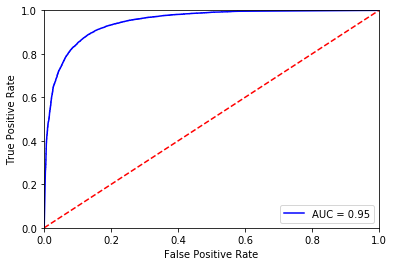

In [23]:
#plot ROC curve
from sklearn import metrics
import matplotlib.pyplot as plt

#vec=pipe.fit(xtrain, yTrain)
#y_pred=vec.predict(xTest)
fpr, tpr, thresholds= metrics.roc_curve(yTest, yPred[:,1])

roc_auc=metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [24]:
#find optimal threshold
def find_optimal_cutoff(target, predicted):
    fpr, tpr, threshold=metrics.roc_curve(target, predicted)
    i=range(len(tpr))
    roc=pd.DataFrame({'tf': pd.Series(tpr-(1-fpr), index=i), 'threshold':pd.Series(threshold, index=i)})
    roc_t=roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    return list(roc_t['threshold'])
find_optimal_cutoff(yTest, yPred[:,1])

[0.47265942349000145]

In [40]:
len(pipe.named_steps['vec'].get_feature_names()) #check how many features

93291

In [30]:
pipe

Pipeline(steps=[('vec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
   ...ty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False))])

In [32]:
pipe.named_steps['vec'].idf_

array([  9.51723319,   9.18076095,  10.43352392, ...,  10.43352392,
        10.43352392,  10.43352392])

In [ ]:
#dummy
#custom transformer to get average words length
from sklearn.base import BaseEstimator, TransformerMixin

class AverageWordLengthExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def avarage_word_length(self, row):
        return np.mean([len(word) for word in row.split()])
    
    def transform(self, df, y=None):
        return df['Title'].apply(self.average_word_length)
    
    def fit(self, df, y=None):
        return self

In [41]:
#use grid search to find the best parameter.
from sklearn.grid_search import GridSearchCV
params={'vec__max_df':(0.5, 0.75, 1),'vec__max_features':(None, 5000,50000, 100000),'vec__ngram_range':((1,1), (1,2))}

grid=GridSearchCV(pipe, param_grid=params, cv=5)
grid.fit(xtrain, yTrain)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('vec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
   ...ty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'vec__max_df': (0.5, 0.75, 1), 'vec__max_features': (None, 5000, 50000, 100000), 'vec__ngram_range': ((1, 1), (1, 2))},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [42]:
grid.best_params_

{'vec__max_df': 0.5, 'vec__max_features': 100000, 'vec__ngram_range': (1, 2)}

In [43]:
grid.best_score_

0.89452

In [45]:
#the second round
#model
vectorizer1=TfidfVectorizer(max_df=0.5, max_features=100000, ngram_range=(1,2), strip_accents='unicode')
kbest1=SelectPercentile(chi2)
clf1=SGDClassifier(loss='modified_huber', penalty='elasticnet')

pipe1=Pipeline([('vec', vectorizer1), ('kbest', kbest1), ('clf', clf1)])
#pipe.fit(Xtrain).predict()
#use cross validation to do classification, if score returned for different round are close to each other, then, it's robust
scores1=cross_val_score(pipe1, xtrain, yTrain, cv=10, scoring='accuracy', n_jobs=-1)
scores1

[ 0.8916  0.8908  0.9096  0.8884  0.8908  0.89    0.8968  0.8956  0.8852
  0.898 ]


In [46]:
np.mean(scores1)

0.89368000000000003

In [48]:
np.mean(scores)

0.89051999999999987

In [74]:
yPred=pipe1.fit(xtrain, yTrain).predict_proba(xTest)

In [69]:
sum(yPred & yTest) / len(yPred)

0.44603999999999999

In [9]:
#training use random forest
from sklearn.ensemble import RandomForestClassifier

print('vectorizing...')
tfidfvec1=TfidfVectorizer(max_df=0.5, max_features=100000, ngram_range=(1,4), strip_accents='unicode')
tfidfvec1=tfidfvec1.fit(xtrain+xTest)
trainFea=tfidfvec1.transform(xtrain)
testFea=tfidfvec1.transform(xTest)

print('reducing dimension...')
from sklearn.feature_selection.univariate_selection import SelectKBest, chi2, f_classif

fselect=SelectKBest(chi2, k=70000)
trainFea=fselect.fit_transform(trainFea, yTrain)
testFea=fselect.transform(testFea)

print('training...')
rfc=RandomForestClassifier(n_estimators=100)
y_pred=rfc.fit(trainFea, yTrain).predict(testFea)
print(sum(y_pred & yTest) / len(yPred))

vectorizing...
reducing dimension...
training...


NameError: name 'yPred' is not defined

In [10]:
print(sum(y_pred & yTest) / len(y_pred))

0.4236


In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier

#prepare data
xtrain=dfTrain['review']
yTrain=dfTrain['class']
xTest=dfTest['review']
yTest=dfTest['class']

print('vectorizing...')
tfidfvec1=TfidfVectorizer(min_df=2, max_df=0.95, max_features=200000, ngram_range=(1,4), sublinear_tf=True)
tfidfvec1=tfidfvec1.fit(xtrain+xTest)
trainFea=tfidfvec1.transform(xtrain)
testFea=tfidfvec1.transform(xTest)

print('reducing dimensions...')
from sklearn.feature_selection.univariate_selection import SelectKBest, chi2, f_classif
fselect=SelectKBest(chi2, k=70000)
trainFea=fselect.fit_transform(trainFea, yTrain)
testFea=fselect.transform(testFea)

print('training using multi nomial NB')
model1=MultinomialNB(alpha=0.0005)
model1=model1.fit(trainFea, yTrain)
p1=model1.predict_proba(testFea)[:,1]

print('trianing using SGD')
model2=SGDClassifier(loss='modified_huber', n_iter=5, random_state=0, shuffle=True)
model2=model2.fit(trainFea, yTrain)
p2=model2.predict_proba(testFea)[:,1]

print('results...')
p=0.2*p1+1.*p2

vectorizing...
reducing dimensions...
training using multi nomial NB
trianing using SGD
results...


In [12]:
p3=model1.predict_proba(testFea)
p4=model2.predict_proba(testFea)
p5=0.2*p3+1.*p4

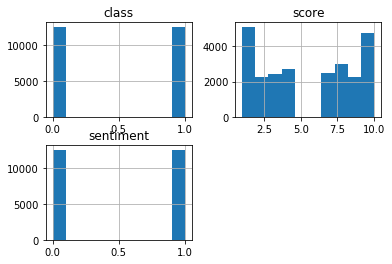

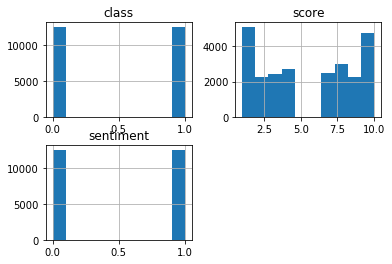

In [28]:
dfTrain.hist()
plt.show()